In [1]:
%matplotlib inline

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import signal

In [4]:
import os
import sys
import re

In [5]:
BITRATE = 16                      # Bit rate
SAMRATE = 16000                   # Sample rate (Hz)
SAMTIME = 1000.0 / SAMRATE        # Sample time (ms)
MAXAMPS = float(2**BITRATE / 2)   # Max samples amplitute

In [6]:
# Tensorflow setup
sess = None
tf.logging.set_verbosity(tf.logging.INFO)

def reset_vars():
    """Initializes all tf variables"""
    sess.run(tf.global_variables_initializer())

def reset_tf():
    """Closes the current tf session and opens new session"""
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

## Create tensorflow preprocessing functions

Need functions for...

- Mel spectrogram (use `tf.contrib.signal library`)
- MFCCs (use `tf.contrib.signal library`)
- Zero crossing rate
- RMSE
- Window function

In [7]:
reset_tf()

In [8]:
# Test arrays
a = tf.placeholder(tf.float32, [1200,], name='a')
a2 = tf.placeholder(tf.float32, [5, 1200], name='a2')

b = 1.0 * np.arange(1200)
b2 = np.array([1.0 * np.arange(1200), 0.2 * np.arange(1200), 0.01 * np.arange(1200)])

c = np.array([1,2,4,-5,-6,-1,1,2,1,1,-1,1,4])
d = np.array([[1,2,3], [-4,5,6]])
d2 = np.array([[[1,2,3], [-4,5,6]],
               [[-1,2,3], [-4,5,6]],
               [[1,-2,3], [-4,5,6]],
               [[1,2,-3], [-4,5,6]]])
f = 0.8 * (np.random.rand(1200) - 0.5) + 0.5 * np.sin(0.2 * np.arange(1200)) + 0.5 * np.sin(0.05 * np.arange(1200))

In [9]:
def windower(arr, window=128, hop_length=32, rank=1):
    """Windower function that divides an array into fixed size windows"""
    overlap = window - hop_length
    length = arr.shape[rank - 1]
    indexer = tf.range(window)[None, :] + hop_length * tf.range((length - overlap) / hop_length)[:, None]
    return tf.gather(arr, indexer, axis=rank - 1)

In [10]:
windower(a)

<tf.Tensor 'Gather:0' shape=(34, 128) dtype=float32>

In [11]:
windower(a2, rank=2)

<tf.Tensor 'GatherV2:0' shape=(5, 34, 128) dtype=float32>

In [12]:
windower(b2, rank=2)

<tf.Tensor 'GatherV2_1:0' shape=(3, 34, 128) dtype=float64>

In [13]:
windower(b, rank=1)

<tf.Tensor 'Gather_1:0' shape=(34, 128) dtype=float64>

In [14]:
sess.run(windower(b2, rank=2))

array([[[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
           1.25000000e+02,   1.26000000e+02,   1.27000000e+02],
        [  3.20000000e+01,   3.30000000e+01,   3.40000000e+01, ...,
           1.57000000e+02,   1.58000000e+02,   1.59000000e+02],
        [  6.40000000e+01,   6.50000000e+01,   6.60000000e+01, ...,
           1.89000000e+02,   1.90000000e+02,   1.91000000e+02],
        ..., 
        [  9.92000000e+02,   9.93000000e+02,   9.94000000e+02, ...,
           1.11700000e+03,   1.11800000e+03,   1.11900000e+03],
        [  1.02400000e+03,   1.02500000e+03,   1.02600000e+03, ...,
           1.14900000e+03,   1.15000000e+03,   1.15100000e+03],
        [  1.05600000e+03,   1.05700000e+03,   1.05800000e+03, ...,
           1.18100000e+03,   1.18200000e+03,   1.18300000e+03]],

       [[  0.00000000e+00,   2.00000000e-01,   4.00000000e-01, ...,
           2.50000000e+01,   2.52000000e+01,   2.54000000e+01],
        [  6.40000000e+00,   6.60000000e+00,   6.80000000e+0

In [15]:
def tf_diff_axis(arr):
    """Equivalent of np.diff on last axis"""
    return arr[..., 1:] - arr[..., :-1]


def zero_crossing(arr, rank=1):
    """Calculates the zero crossing rate"""
    if rank == 1:
        nzc = tf.cast(tf.count_nonzero(tf_diff_axis(tf.sign(arr))), tf.float32)
    else:
        nzc = tf.cast(tf.count_nonzero(tf_diff_axis(tf.sign(arr)), axis=rank - 1), tf.float32)

    arrlen = tf.cast(arr.shape[rank - 1], tf.float32)
    return tf.divide(nzc, arrlen, name='zcr')

In [16]:
tf_diff_axis(d2)

array([[[ 1,  1],
        [ 9,  1]],

       [[ 3,  1],
        [ 9,  1]],

       [[-3,  5],
        [ 9,  1]],

       [[ 1, -5],
        [ 9,  1]]])

In [17]:
d

array([[ 1,  2,  3],
       [-4,  5,  6]])

In [18]:
tf_diff_axis(c)

array([ 1,  2, -9, -1,  5,  2,  1, -1,  0, -2,  2,  3])

In [19]:
sess.run(zero_crossing(d, rank=2))

array([ 0.        ,  0.33333334], dtype=float32)

In [20]:
sess.run(zero_crossing(c, rank=1))

0.30769232

In [21]:
def rms_energy(arr, rank=1, maxamps=1.0):
    """Calculates the RMS energy of the wave"""
    if rank == 1:
        return tf.sqrt(tf.reduce_mean(tf.square(arr / maxamps)), name='rmse')
    else:
        return tf.sqrt(tf.reduce_mean(tf.square(arr / maxamps), axis=rank - 1), name='rmse')

In [22]:
# My windower function is faster
sess.run(signal.frame(b, 128, 32))

array([[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          1.25000000e+02,   1.26000000e+02,   1.27000000e+02],
       [  3.20000000e+01,   3.30000000e+01,   3.40000000e+01, ...,
          1.57000000e+02,   1.58000000e+02,   1.59000000e+02],
       [  6.40000000e+01,   6.50000000e+01,   6.60000000e+01, ...,
          1.89000000e+02,   1.90000000e+02,   1.91000000e+02],
       ..., 
       [  9.92000000e+02,   9.93000000e+02,   9.94000000e+02, ...,
          1.11700000e+03,   1.11800000e+03,   1.11900000e+03],
       [  1.02400000e+03,   1.02500000e+03,   1.02600000e+03, ...,
          1.14900000e+03,   1.15000000e+03,   1.15100000e+03],
       [  1.05600000e+03,   1.05700000e+03,   1.05800000e+03, ...,
          1.18100000e+03,   1.18200000e+03,   1.18300000e+03]])

In [23]:
stfts = signal.stft(tf.cast(f, tf.float32), frame_length=256, frame_step=16, fft_length=128)

In [24]:
magnitude_spectrograms = tf.abs(stfts)

In [25]:
# Warp the linear-scale, magnitude spectrograms into the mel-scale
num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
lower_edge_hertz = 80.0
upper_edge_hertz = 7600.0
num_mel_bins = 64

mel_weight_mat = signal.linear_to_mel_weight_matrix(num_mel_bins,
                                                    num_spectrogram_bins,
                                                    SAMRATE,
                                                    lower_edge_hertz,
                                                    upper_edge_hertz)

mel_spectrograms = tf.tensordot(magnitude_spectrograms, mel_weight_mat, 1)

# Note: Shape inference for tf.tensordot does not currently handle this case
mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(mel_weight_mat.shape[-1:]))

In [26]:
x1 = sess.run(mel_spectrograms)

In [27]:
# Matmul only works for single file, hence use of tensordot
x2 = sess.run(tf.matmul(magnitude_spectrograms, mel_weight_mat))

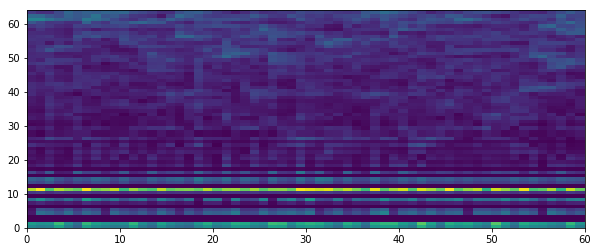

In [28]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(x1.T);

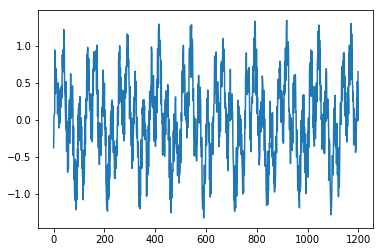

In [29]:
plt.plot(f);

### Function for full batch process

In [30]:
def signalProcessBatch(signals, add_noise=False, window=512, maxamps=1.0, sr=16000,
                       num_mel_bins=64, num_mfccs=19):
    """Function to perform all the DSP preprocessing and feature extraction.
       Returns the Mel spectrum, MFCCs, ZCR and RMSE.
       Works on a batch of num_files files.
       Input signals : [num_files, samples]
       Output        : [num_files, num_windows, num_mfccs]"""
    
    hop_length = window / 4
    signals32 = tf.cast(signals, tf.float32)
    signals_w = windower(signals32, window=window, hop_length=hop_length, rank=2)

    zcr = zero_crossing(signals_w, rank=3)
    rmse = rms_energy(signals_w, rank=3, maxamps=maxamps)

    stfts = signal.stft(signals32, frame_length=window, frame_step=hop_length, fft_length=window)
    magnitude_spectrograms = tf.abs(stfts)

    num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
    lower_edge_hertz = 80.0
    upper_edge_hertz = 7600.0

    mel_weight_mat = signal.linear_to_mel_weight_matrix(num_mel_bins,
                                                        num_spectrogram_bins,
                                                        sr,
                                                        lower_edge_hertz,
                                                        upper_edge_hertz)

    mel_spectrograms = tf.tensordot(magnitude_spectrograms, mel_weight_mat, 1, name='mel_spectrograms')
    mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(mel_weight_mat.shape[-1:]))

    log_offset = 1e-6
    log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

    mfccs = signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    mfccs = tf.identity(mfccs, name='mfccs')

    return mfccs, mel_spectrograms, zcr, rmse

In [31]:
signalProcessBatch(a2)

(<tf.Tensor 'mfccs:0' shape=(5, 6, 19) dtype=float32>,
 <tf.Tensor 'mel_spectrograms:0' shape=(5, 6, 64) dtype=float32>,
 <tf.Tensor 'zcr_2:0' shape=(5, 6) dtype=float32>,
 <tf.Tensor 'rmse:0' shape=(5, 6) dtype=float32>)

In [32]:
sess.run(signalProcessBatch(b2))

(array([[[ -7.97368336e+00,   2.06113586e+01,   3.75430226e+00,
            4.47038746e+00,   1.39043033e+00,   2.18870497e+00,
            7.63252497e-01,   1.26080108e+00,   5.33654094e-01,
            8.19303393e-01,   3.44486326e-01,   6.39874578e-01,
            1.91176161e-01,   5.10968804e-01,   1.66255653e-01,
            3.46299589e-01,   1.95357293e-01,   2.53275365e-01,
            1.61378682e-01],
         [ -7.88821268e+00,   2.05286121e+01,   3.82394075e+00,
            4.42403030e+00,   1.41814065e+00,   2.16388273e+00,
            7.94786096e-01,   1.22399473e+00,   5.72098374e-01,
            7.83643782e-01,   3.66761774e-01,   6.46006823e-01,
            1.53874680e-01,   5.59329450e-01,   1.31584644e-01,
            3.61418575e-01,   1.86324894e-01,   2.67494380e-01,
            1.43682137e-01],
         [ -7.77652788e+00,   2.04241581e+01,   3.91003108e+00,
            4.36067152e+00,   1.46339250e+00,   2.12223077e+00,
            8.45508993e-01,   1.16232324e+00, 

### Testing on some audio files